In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from itertools import cycle

from sklearn import metrics

from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler, LabelBinarizer



### Load Data:

In [2]:
# load training data 

df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
# load test data 

df_test = pd.read_csv('data/test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


Create features sets required to subset the original dataframes into original features and original + extracted features

Create training and test data labels series, and convert them to binary format as required by multiclass classification algorithms.


In [4]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_mcc']
y_test = df_test['label_mcc']

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)


### Multiclass Classification:

Let us add some helper fuctions

In [5]:
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
       
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        OvR (bool): True if the classifier inherently support multiclass One-Vs-Rest
        prob (str): For getting classification scores: 'P' for predict_proba, 'D' for decision_function
        
    Returns:
        Tuned Clssifier object
        array: prediction values
        array: prediction scores
    
    
    """
    
    
    X_train = df_train[features]

    X_test = df_test[features] 
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    
    return grid_search.best_estimator_, y_pred, y_score


In [6]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main multiclass classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dict: ROC thresholds
        dict: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
  
    
    """
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        }
    
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model]

   
    n_classes = y_train.shape[1]
    
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        #fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[i][:,0])
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    
    
    
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        #precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[i][:,0])
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:
        
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
        
        
        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
            
        ax2.plot(recall["micro"], precision["micro"], color='deeppink', lw=4, linestyle=':', label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')
    
    return df_metrics, df_prc_thresh, df_roc_thresh

Using the above functions let us model and evaluate some binary classification algorithms

__In model names:__  

__B__ stands for applying the model on the original features set, __B__efore feature extraction  
__A__ stands for applying the model on the original + extracted features set, __A__fter feature extraction


Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[74  1  0]
 [12  2  1]
 [ 1  0  9]]

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.99      0.91        75
          1       0.67      0.13      0.22        15
          2       0.90      0.90      0.90        10

avg / total       0.83      0.85      0.81       100


Metrics:
                 Decision Tree B
macro F1                0.684053
micro F1                0.861538
micro Precision         0.884211
micro ROC AUC           0.956625
macro ROC AUC           0.905594
macro Precision         0.818970
micr

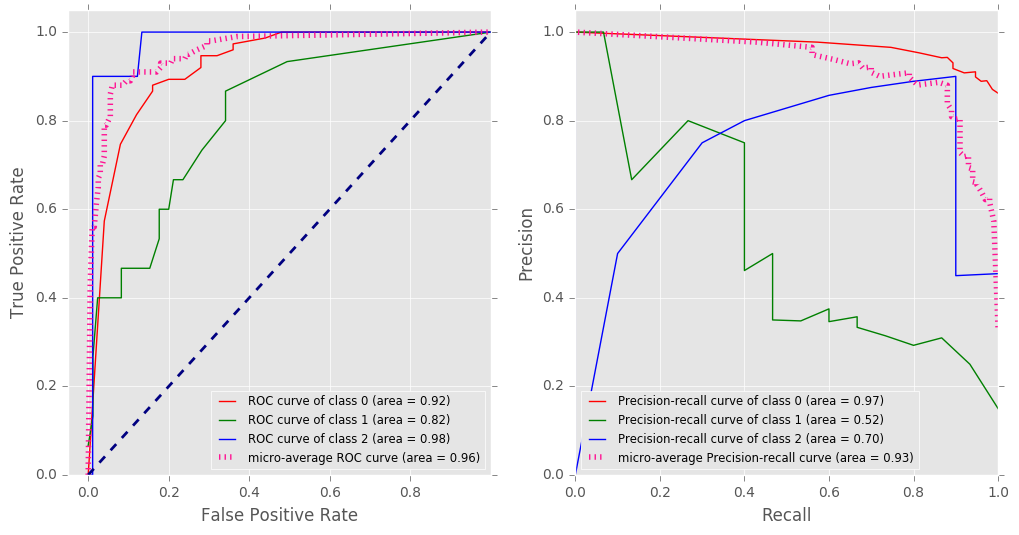

In [7]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtrb, y_pred_dtrb, y_score_dtrb = multiclass_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtrb)

metrics_dtrb, prc_dtrb, roc_dtrb = multiclass_metrics(model, y_test, y_pred_dtrb, y_score_dtrb, print_out=True, plot_out=True)



Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree A 

Confusion Matrix:
[[74  0  1]
 [10  1  4]
 [ 1  0  9]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.99      0.93        75
          1       1.00      0.07      0.12        15
          2       0.64      0.90      0.75        10

avg / total       0.87      0.84      0.79       100


Metrics:
                 Decision Tree A
macro F1                0.607906
micro F1                0.857143
micro Precision         0.875000
micro ROC AUC           0.973550
macro ROC AUC           0.949857
macro Precision         0.852146
micr

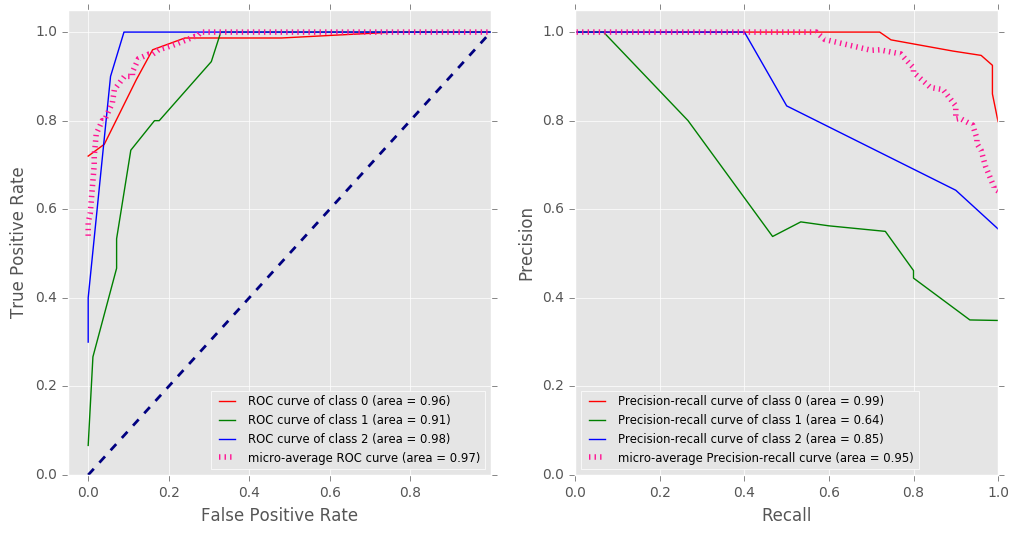

In [8]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtra, y_pred_dtra, y_score_dtra = multiclass_classify(model, clf_dtrb, 
                                            features_extr, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtra)

metrics_dtra, prc_dtra, roc_dtra = multiclass_metrics(model, y_test, y_pred_dtra, y_score_dtra, print_out=True, plot_out=True)


In [9]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

,Decision Tree B,Decision Tree A
macro F1,0.684053,0.607906
micro F1,0.861538,0.857143
micro Precision,0.884211,0.875000
micro ROC AUC,0.956625,0.973550
macro ROC AUC,0.905594,0.949857
macro Precision,0.818970,0.852146
micro Recall,0.840000,0.840000
Accuracy,0.840000,0.840000
macro Recall,0.668889,0.651111



Best Parameters:
 OneVsRestClassifier(estimator=LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0),
          n_jobs=1)
-----------------------------------------------------------
SVC Linear B 

Confusion Matrix:
[[75  0  0]
 [14  0  1]
 [ 6  0  4]]

Classification Report:
             precision    recall  f1-score   support

          0       0.79      1.00      0.88        75
          1       0.00      0.00      0.00        15
          2       0.80      0.40      0.53        10

avg / total       0.67      0.79      0.72       100


Metrics:
                 SVC Linear B
macro F1             0.482540
micro F1             0.800000
micro Precision      0.971429
micro ROC AUC        0.953650
macro ROC AUC        0.934652
macro Precision      0.594872
micro Recall         0.680000
Accuracy             0.680000
macro Recall  

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


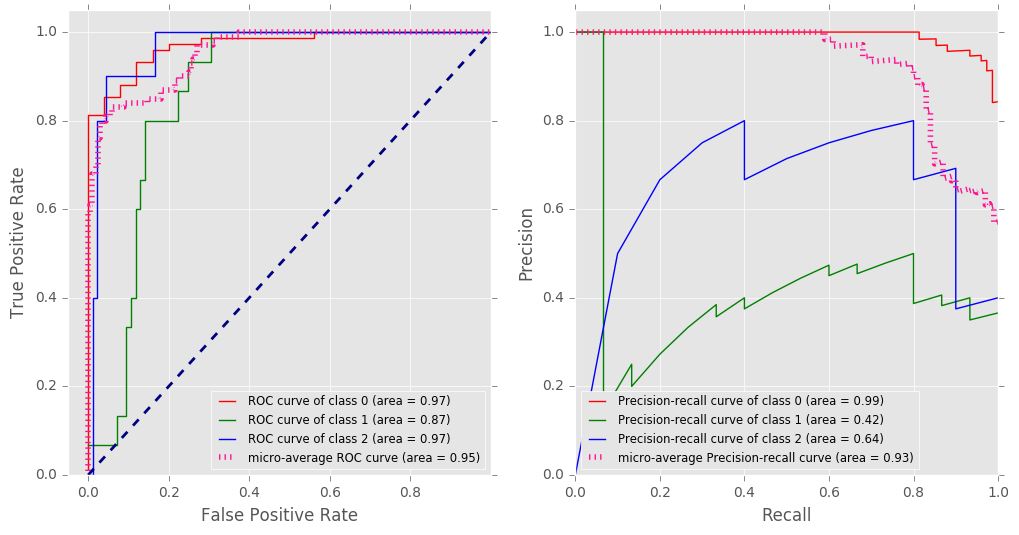

In [10]:
model = 'SVC Linear B'

clf_svlb = OneVsRestClassifier(LinearSVC(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0]}
gs_score = 'roc_auc'


clf_svlb, y_pred_svlb, y_score_svlb = multiclass_classify(model, clf_svlb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False, prob='D')
print('\nBest Parameters:\n',clf_svlb)

metrics_svlb, prc_svlb, roc_svlb = multiclass_metrics(model, y_test, y_pred_svlb, y_score_svlb, print_out=True, plot_out=True)



Best Parameters:
 OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0),
          n_jobs=1)
-----------------------------------------------------------
SVC Linear A 

Confusion Matrix:
[[75  0  0]
 [13  2  0]
 [ 2  8  0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.83      1.00      0.91        75
          1       0.20      0.13      0.16        15
          2       0.00      0.00      0.00        10

avg / total       0.66      0.77      0.71       100


Metrics:
                 SVC Linear A
macro F1             0.501098
micro F1             0.630137
micro Precision      0.479167
micro ROC AUC        0.917200
macro ROC AUC        0.943288
macro Precision      0.661111
micro Recall         0.920000
Accuracy             0.020000
macro Recall  

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


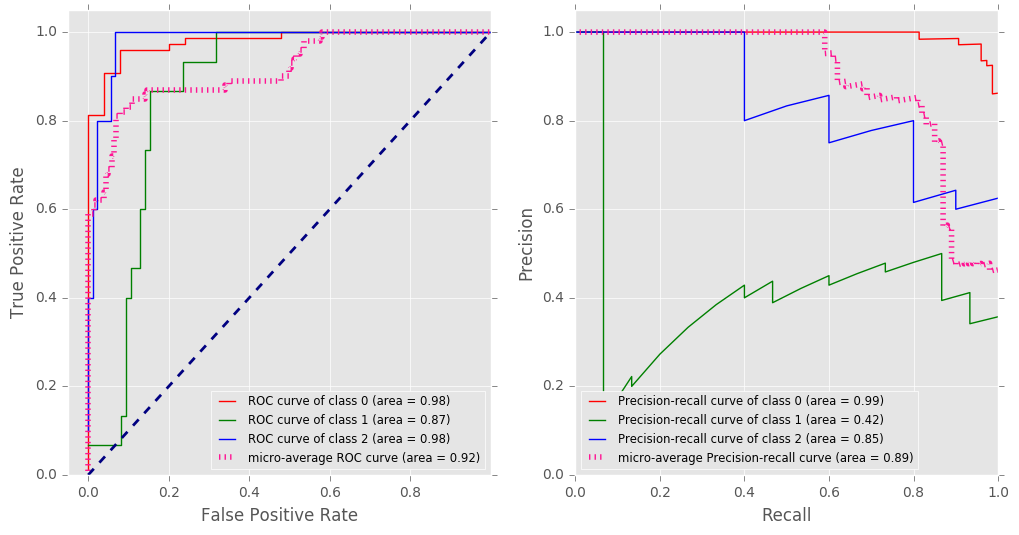

In [11]:
model = 'SVC Linear A'

clf_svla = OneVsRestClassifier(LinearSVC(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0]}
gs_score = 'roc_auc'


clf_svla, y_pred_svla, y_score_svla = multiclass_classify(model, clf_svla, features_extr, params=gs_params, score=gs_score, scale=False, OvR=False, prob='D')
print('\nBest Parameters:\n',clf_svla)

metrics_svla, prc_svla, roc_svla = multiclass_metrics(model, y_test, y_pred_svla, y_score_svla, print_out=True, plot_out=True)


In [12]:
metrics_svl = pd.concat([metrics_svlb, metrics_svla], axis=1)
metrics_svl

,SVC Linear B,SVC Linear A
macro F1,0.482540,0.501098
micro F1,0.800000,0.630137
micro Precision,0.971429,0.479167
micro ROC AUC,0.953650,0.917200
macro ROC AUC,0.934652,0.943288
macro Precision,0.594872,0.661111
micro Recall,0.680000,0.920000
Accuracy,0.680000,0.020000
macro Recall,0.417778,0.733333



Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[75  0  0]
 [13  0  2]
 [ 3  0  7]]

Classification Report:
             precision    recall  f1-score   support

          0       0.82      1.00      0.90        75
          1       0.00      0.00      0.00        15
          2       0.78      0.70      0.74        10

avg / total       0.70      0.82      0.75       100


Metrics:
                 Logistic Regression B
macro F1                      0.557850
micro F1                      0.843750
micro Precision               0.880435
micro ROC AUC                 0.970550
macro ROC AUC                 0.9

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


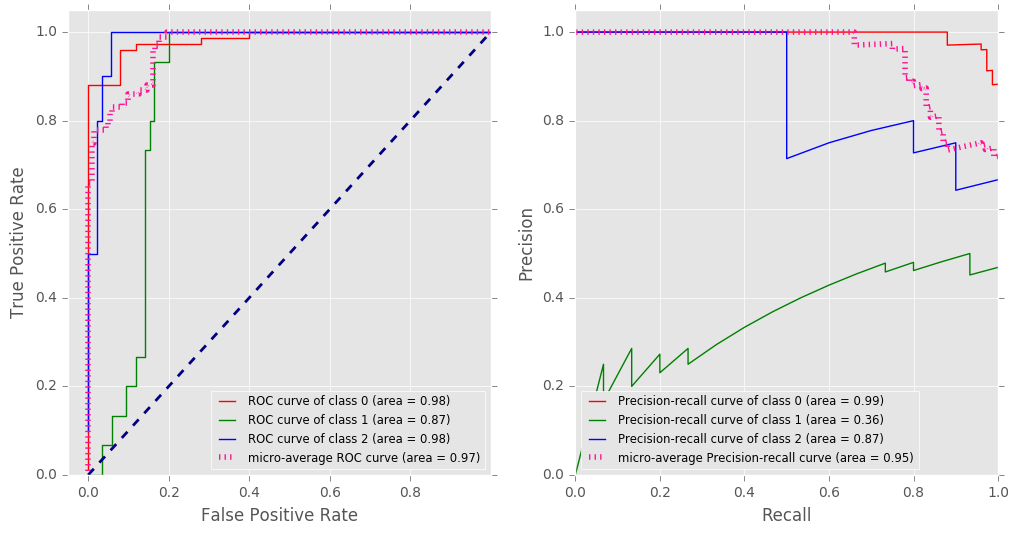

In [13]:
model = 'Logistic Regression B'

clf_lgrb = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgrb, y_pred_lgrb, y_score_lgrb = multiclass_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, prc_lgrb, roc_lgrb = multiclass_metrics(model, y_test, y_pred_lgrb, y_score_lgrb, print_out=True, plot_out=True)



Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)
-----------------------------------------------------------
Logistic Regression A 

Confusion Matrix:
[[75  0  0]
 [14  0  1]
 [ 4  0  6]]

Classification Report:
             precision    recall  f1-score   support

          0       0.81      1.00      0.89        75
          1       0.00      0.00      0.00        15
          2       0.86      0.60      0.71        10

avg / total       0.69      0.81      0.74       100


Metrics:
                 Logistic Regression A
macro F1                      0.551750
micro F1                      0.852632
micro Precision               0.900000
micro ROC AUC                 0.971800
macro ROC AUC                 0.941

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


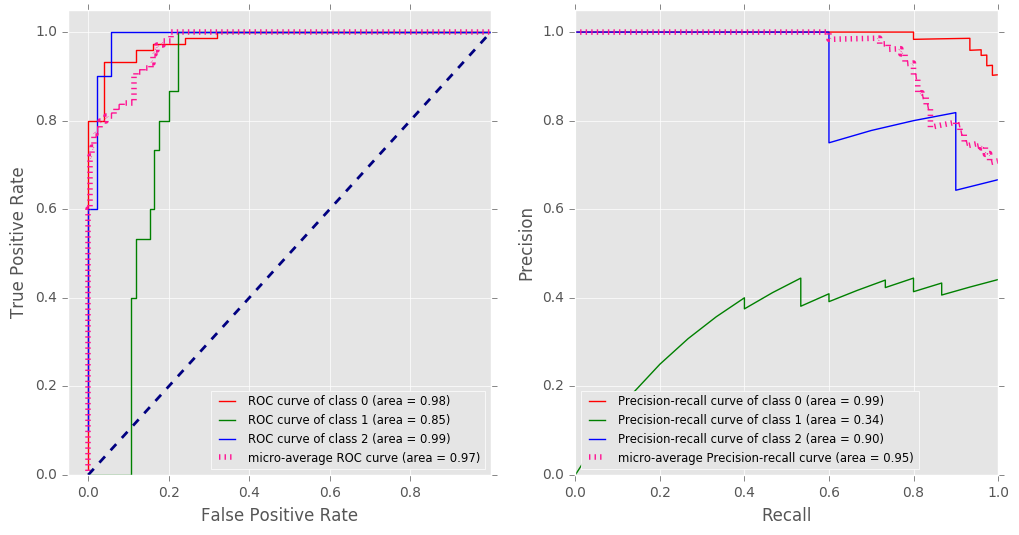

In [14]:
model = 'Logistic Regression A'

clf_lgra = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgra, y_pred_lgra, y_score_lgra = multiclass_classify(model, clf_lgra, features_extr, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, prc_lgra, roc_lgra = multiclass_metrics(model, y_test, y_pred_lgra, y_score_lgra, print_out=True, plot_out=True)


In [15]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
macro F1,0.557850,0.551750
micro F1,0.843750,0.852632
micro Precision,0.880435,0.900000
micro ROC AUC,0.970550,0.971800
macro ROC AUC,0.945204,0.941515
macro Precision,0.556448,0.586919
micro Recall,0.810000,0.810000
Accuracy,0.810000,0.810000
macro Recall,0.562222,0.533333



Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[75  0  0]
 [11  2  2]
 [ 3  1  6]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      1.00      0.91        75
          1       0.67      0.13      0.22        15
          2       0.75      0.60      0.67        10

avg / total       0.81      0.83      0.79       100


Metrics:
                 Random Forest B
macro F1                0.612536
micro F1                0.854167
micro Precision         0.891304
micro ROC AUC           0.978500

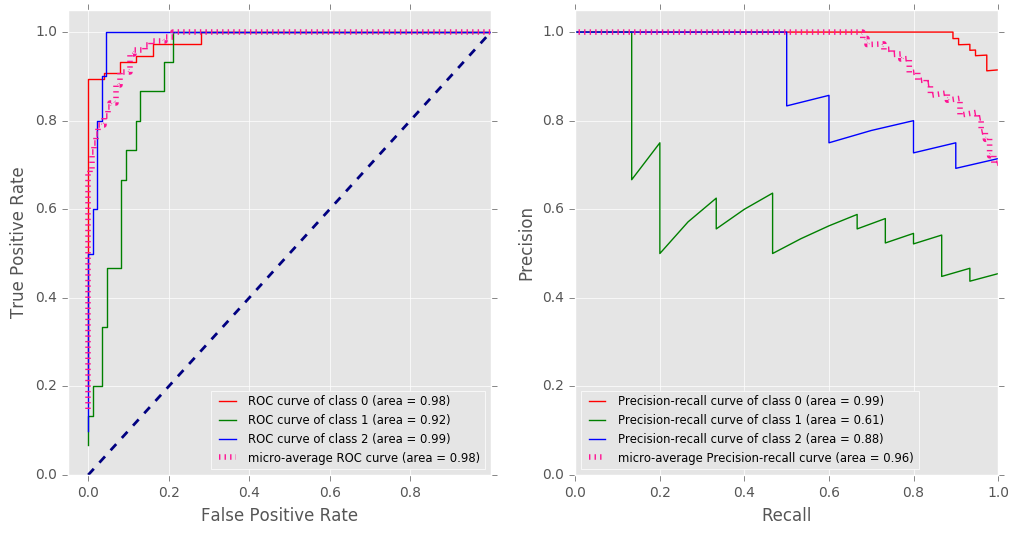

In [16]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfcb, y_pred_rfcb, y_score_rfcb = multiclass_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, prc_rfcb, roc_rfcb = multiclass_metrics(model, y_test, y_pred_rfcb, y_score_rfcb, print_out=True, plot_out=True)




Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest A 

Confusion Matrix:
[[74  1  0]
 [12  3  0]
 [ 0  2  8]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.99      0.92        75
          1       0.50      0.20      0.29        15
          2       1.00      0.80      0.89        10

avg / total       0.82      0.85      0.82       100


Metrics:
                 Random Forest A
macro F1                0.705759
micro F1                0.867347
micro Precision         0.885417
micro ROC AUC           0.980600

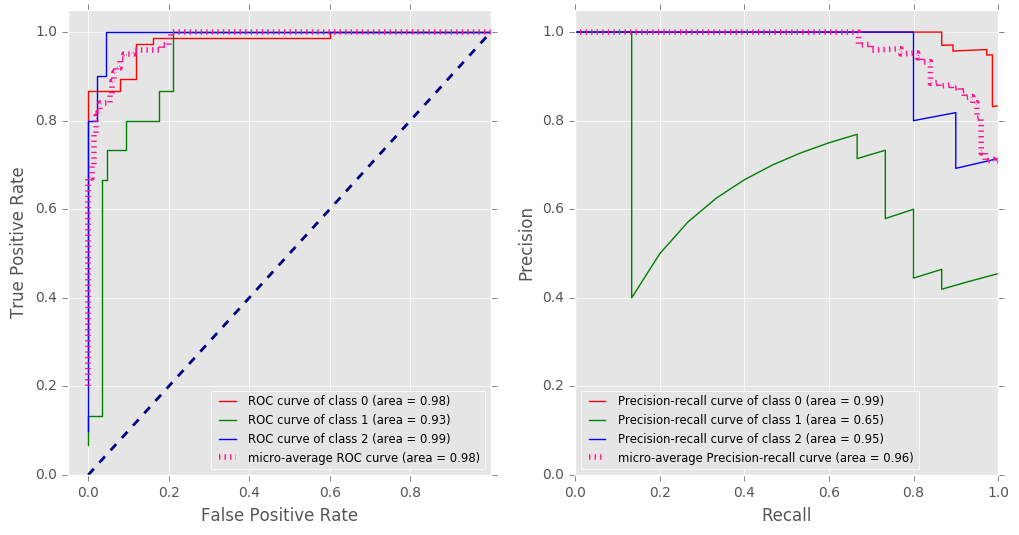

In [17]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfca, y_pred_rfca, y_score_rfca = multiclass_classify(model, clf_rfca, features_extr, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, prc_rfca, roc_rfca = multiclass_metrics(model, y_test, y_pred_rfca, y_score_rfca, print_out=True, plot_out=True)



In [18]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

,Random Forest B,Random Forest A
macro F1,0.612536,0.705759
micro F1,0.854167,0.867347
micro Precision,0.891304,0.885417
micro ROC AUC,0.978500,0.980600
macro ROC AUC,0.964340,0.967744
macro Precision,0.776749,0.800813
micro Recall,0.820000,0.850000
Accuracy,0.820000,0.850000
macro Recall,0.573333,0.662222



Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN B 

Confusion Matrix:
[[75  0  0]
 [10  3  2]
 [ 3  1  6]]

Classification Report:
             precision    recall  f1-score   support

          0       0.85      1.00      0.92        75
          1       0.75      0.20      0.32        15
          2       0.75      0.60      0.67        10

avg / total       0.83      0.84      0.80       100


Metrics:
                    KNN B
macro F1         0.641710
micro F1         0.855670
micro Precision  0.882979
micro ROC AUC    0.954825
macro ROC AUC    0.904947
macro Precision  0.800813
micro Recall     0.830000
Accuracy         0.830000
macro Recall     0.595556


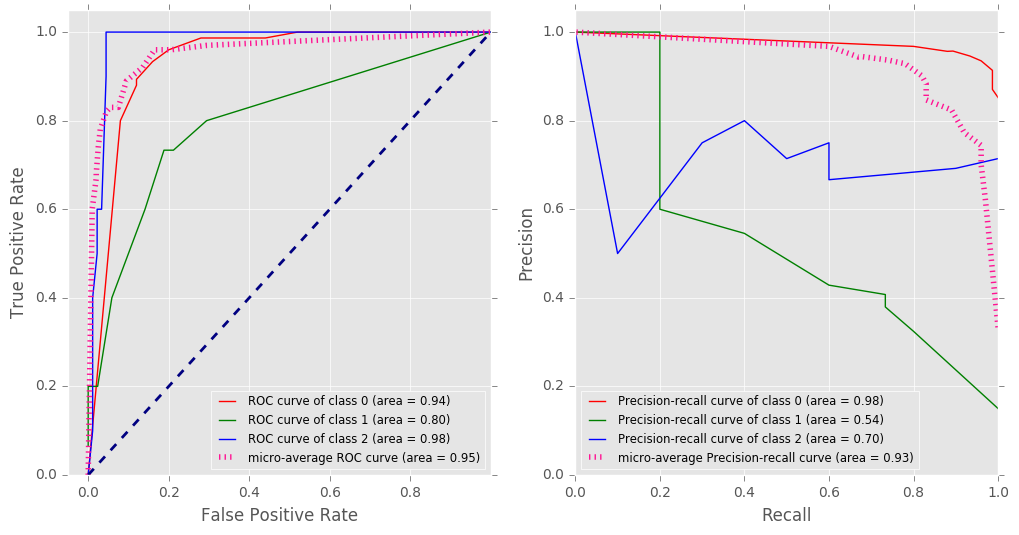

In [19]:
model = 'KNN B'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'


clf_knnb, y_pred_knnb, y_score_knnb = multiclass_classify(model, clf_knnb, features_orig, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n', clf_knnb)

metrics_knnb, prc_knnb, roc_knnb = multiclass_metrics(model, y_test, y_pred_knnb, y_score_knnb, print_out=True, plot_out=True)



Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN A 

Confusion Matrix:
[[74  1  0]
 [ 9  4  2]
 [ 1  1  8]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.99      0.93        75
          1       0.67      0.27      0.38        15
          2       0.80      0.80      0.80        10

avg / total       0.84      0.86      0.84       100


Metrics:
                    KNN A
macro F1         0.709890
micro F1         0.873096
micro Precision  0.886598
micro ROC AUC    0.973525
macro ROC AUC    0.949892
macro Precision  0.793416
micro Recall     0.860000
Accuracy         0.860000
macro Recall     0.684444


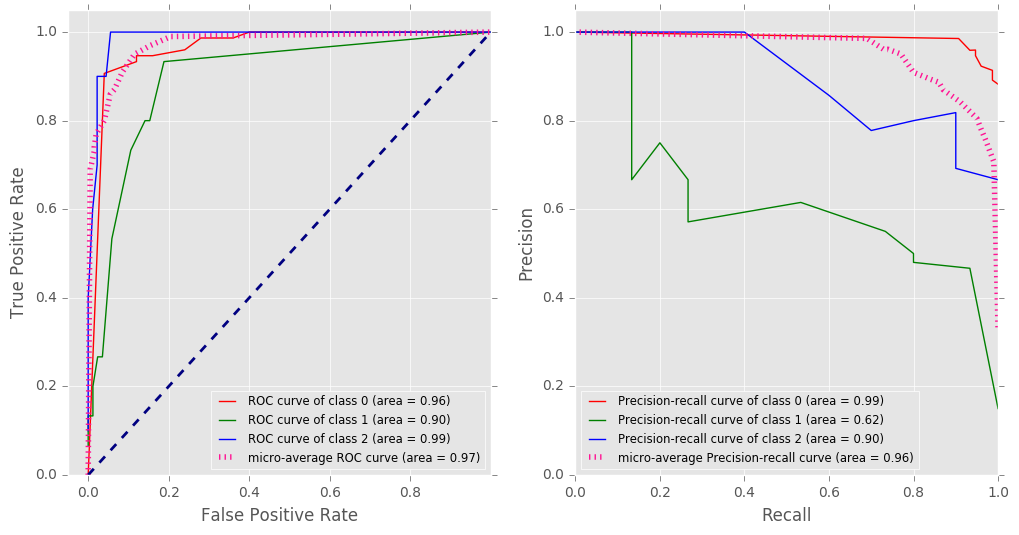

In [20]:
model = 'KNN A'
clf_knna = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'


clf_knna, y_pred_knna, y_score_knna = multiclass_classify(model, clf_knna, features_extr, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n', clf_knna)

metrics_knna, prc_knna, roc_knna = multiclass_metrics(model, y_test, y_pred_knna, y_score_knna, print_out=True, plot_out=True)


In [21]:
metrics_knn = pd.concat([metrics_knnb, metrics_knna], axis=1)
metrics_knn

,KNN B,KNN A
macro F1,0.641710,0.709890
micro F1,0.855670,0.873096
micro Precision,0.882979,0.886598
micro ROC AUC,0.954825,0.973525
macro ROC AUC,0.904947,0.949892
macro Precision,0.800813,0.793416
micro Recall,0.830000,0.860000
Accuracy,0.830000,0.860000
macro Recall,0.595556,0.684444



Best Parameters:
 OneVsRestClassifier(estimator=GaussianNB(priors=None), n_jobs=1)
-----------------------------------------------------------
Gaussian NB B 

Confusion Matrix:
[[70  5  0]
 [ 1 14  0]
 [ 0 10  0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.93      0.96        75
          1       0.48      0.93      0.64        15
          2       0.00      0.00      0.00        10

avg / total       0.81      0.84      0.81       100


Metrics:
                 Gaussian NB B
macro F1              0.757853
micro F1              0.852018
micro Precision       0.772358
micro ROC AUC         0.962650
macro ROC AUC         0.950334
macro Precision       0.655592
micro Recall          0.950000
Accuracy              0.740000
macro Recall          0.977778


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


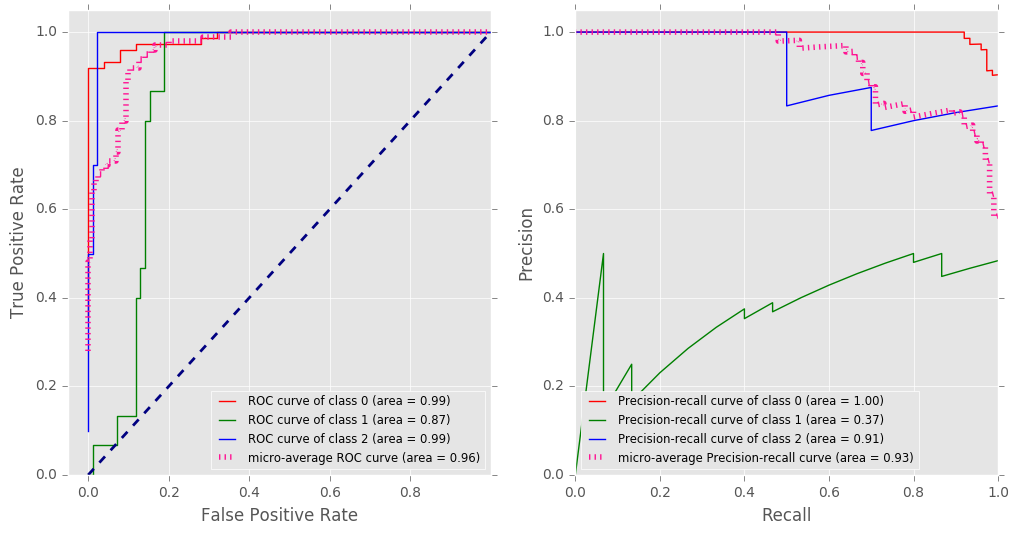

In [22]:
model = 'Gaussian NB B'
clf_gnbb = OneVsRestClassifier(GaussianNB())
gs_params = {} 
gs_score = 'roc_auc'


clf_gnbb, y_pred_gnbb, y_score_gnbb = multiclass_classify(model, clf_gnbb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n', clf_gnbb)

metrics_gnbb, prc_gnbb, roc_gnbb = multiclass_metrics(model, y_test, y_pred_gnbb, y_score_gnbb, print_out=True, plot_out=True)



Best Parameters:
 OneVsRestClassifier(estimator=GaussianNB(priors=None), n_jobs=1)
-----------------------------------------------------------
Gaussian NB A 

Confusion Matrix:
[[70  5  0]
 [ 2 13  0]
 [ 0 10  0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.93      0.95        75
          1       0.46      0.87      0.60        15
          2       0.00      0.00      0.00        10

avg / total       0.80      0.83      0.80       100


Metrics:
                 Gaussian NB A
macro F1              0.754954
micro F1              0.849315
micro Precision       0.781513
micro ROC AUC         0.942850
macro ROC AUC         0.944823
macro Precision       0.664502
micro Recall          0.930000
Accuracy              0.740000
macro Recall          0.933333


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


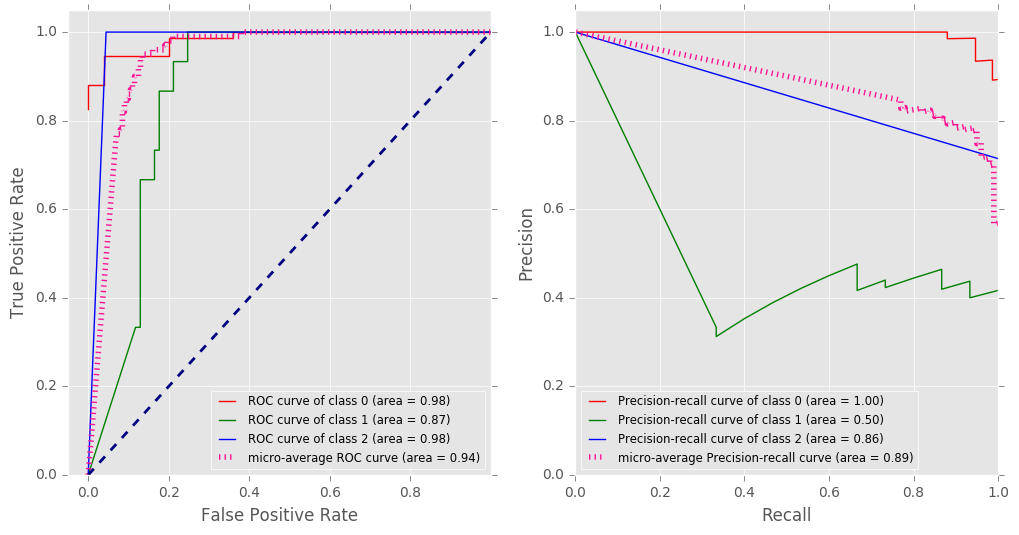

In [23]:
model = 'Gaussian NB A'
clf_gnba = OneVsRestClassifier(GaussianNB())
gs_params = {} 
gs_score = 'roc_auc'


clf_gnba, y_pred_gnba, y_score_gnba = multiclass_classify(model, clf_gnba, features_extr, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n', clf_gnba)

metrics_gnba, prc_gnba, roc_gnba = multiclass_metrics(model, y_test, y_pred_gnba, y_score_gnba, print_out=True, plot_out=True)


In [24]:
metrics_gnb = pd.concat([metrics_gnbb, metrics_gnba], axis=1)
metrics_gnb

,Gaussian NB B,Gaussian NB A
macro F1,0.757853,0.754954
micro F1,0.852018,0.849315
micro Precision,0.772358,0.781513
micro ROC AUC,0.962650,0.942850
macro ROC AUC,0.950334,0.944823
macro Precision,0.655592,0.664502
micro Recall,0.950000,0.930000
Accuracy,0.740000,0.740000
macro Recall,0.977778,0.933333



Best Parameters:
 MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=123,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
-----------------------------------------------------------
Neural Net MLP B 

Confusion Matrix:
[[75  0  0]
 [ 9  5  1]
 [ 2  1  7]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      1.00      0.93        75
          1       0.83      0.33      0.48        15
          2       0.88      0.70      0.78        10

avg / total       0.87      0.87      0.85       100


Metrics:
                 Neural Net MLP B
macro F1                 0.731968
micro F1                 0.876289
micro Precis

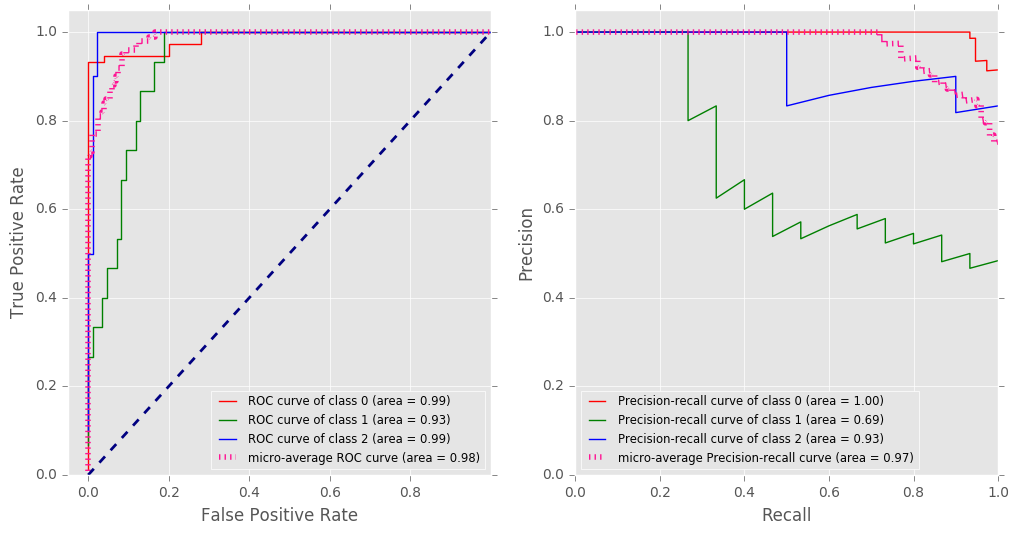

In [25]:
model = 'Neural Net MLP B'
clf_nncb = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'


clf_nncb, y_pred_nncb, y_score_nncb = multiclass_classify(model, clf_nncb, features_orig, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nncb)

metrics_nncb, prc_nncb, roc_nncb = multiclass_metrics(model, y_test, y_pred_nncb, y_score_nncb, print_out=True, plot_out=True)



Best Parameters:
 MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=123,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
-----------------------------------------------------------
Neural Net MLP A 

Confusion Matrix:
[[75  0  0]
 [ 9  5  1]
 [ 0  1  9]]

Classification Report:
             precision    recall  f1-score   support

          0       0.89      1.00      0.94        75
          1       0.83      0.33      0.48        15
          2       0.90      0.90      0.90        10

avg / total       0.88      0.89      0.87       100


Metrics:
                 Neural Net MLP A
macro F1                 0.798057
micro F1                 0.898990
micro Precis

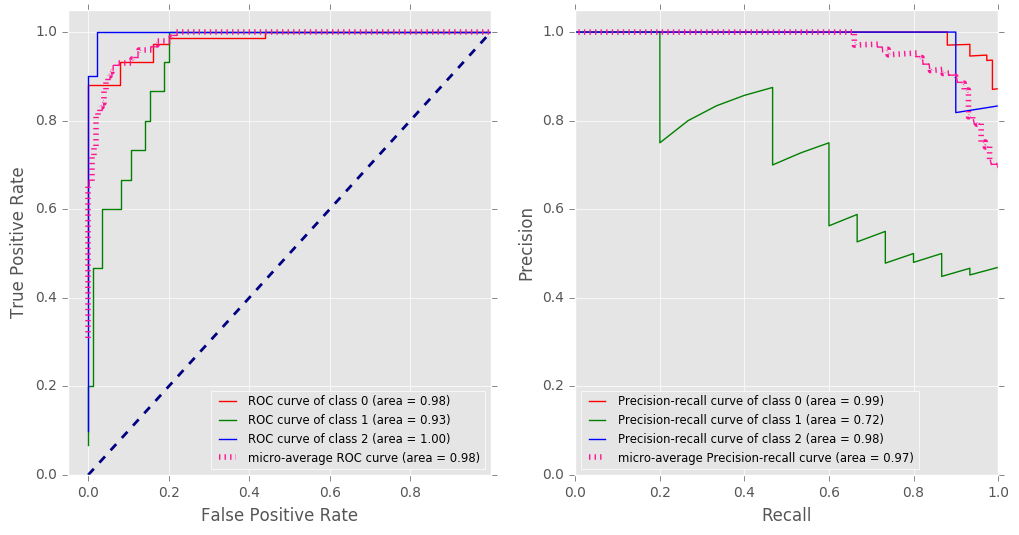

In [26]:
model = 'Neural Net MLP A'
clf_nnca = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'


clf_nnca, y_pred_nnca, y_score_nnca = multiclass_classify(model, clf_nnca, features_extr, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nnca)

metrics_nnca, prc_nnca, roc_nnca = multiclass_metrics(model, y_test, y_pred_nnca, y_score_nnca, print_out=True, plot_out=True)


In [27]:
metrics_nnc = pd.concat([metrics_nncb, metrics_nnca], axis=1)
metrics_nnc

,Neural Net MLP B,Neural Net MLP A
macro F1,0.731968,0.798057
micro F1,0.876289,0.898990
micro Precision,0.904255,0.908163
micro ROC AUC,0.983300,0.981300
macro ROC AUC,0.970588,0.970898
macro Precision,0.873611,0.890241
micro Recall,0.850000,0.890000
Accuracy,0.850000,0.880000
macro Recall,0.668889,0.762222


#### Compare all tried multiclass classification algorithms 

In [28]:
#compare all models
metrics_mc = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc, metrics_svl, metrics_knn, metrics_gnb, metrics_nnc], axis=1).T
metrics_mc

,macro F1,micro F1,micro Precision,micro ROC AUC,macro ROC AUC,macro Precision,micro Recall,Accuracy,macro Recall
Logistic Regression B,0.557850,0.843750,0.880435,0.970550,0.945204,0.556448,0.81,0.81,0.562222
Logistic Regression A,0.551750,0.852632,0.900000,0.971800,0.941515,0.586919,0.81,0.81,0.533333
Decision Tree B,0.684053,0.861538,0.884211,0.956625,0.905594,0.818970,0.84,0.84,0.668889
Decision Tree A,0.607906,0.857143,0.875000,0.973550,0.949857,0.852146,0.84,0.84,0.651111
Random Forest B,0.612536,0.854167,0.891304,0.978500,0.964340,0.776749,0.82,0.82,0.573333
Random Forest A,0.705759,0.867347,0.885417,0.980600,0.967744,0.800813,0.85,0.85,0.662222
SVC Linear B,0.482540,0.800000,0.971429,0.953650,0.934652,0.594872,0.68,0.68,0.417778
SVC Linear A,0.501098,0.630137,0.479167,0.917200,0.943288,0.661111,0.92,0.02,0.733333
KNN B,0.641710,0.855670,0.882979,0.954825,0.904947,0.800813,0.83,0.83,0.595556
KNN A,0.709890,0.873096,0.886598,0.973525,0.949892,0.793416,0.86,0.86,0.684444


Neural Net Multi-layer Perceptron classifier clearly outperformed other models in all metrics, with the
Random Forests classifier scoring in the second place.

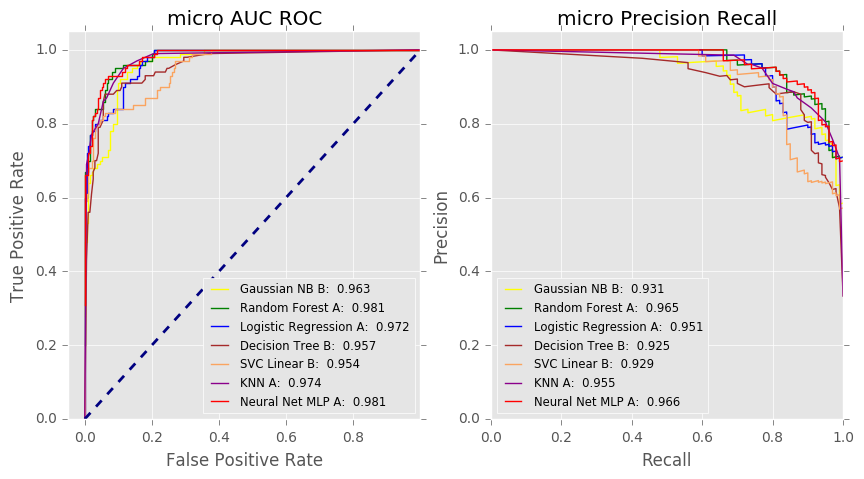

In [29]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)

ax1.plot(roc_gnbb.FPR['micro'], roc_gnbb.TPR['micro'], color='yellow', lw=1, label= roc_gnbb.Model['micro'] + ':  %.3f' % roc_gnbb.AUC['micro'])
ax1.plot(roc_rfca.FPR['micro'], roc_rfca.TPR['micro'], color='green', lw=1, label= roc_rfca.Model['micro'] + ':  %.3f' % roc_rfca.AUC['micro'])
ax1.plot(roc_lgra.FPR['micro'], roc_lgra.TPR['micro'], color='blue', lw=1, label= roc_lgra.Model['micro'] + ':  %.3f' % roc_lgra.AUC['micro'])
ax1.plot(roc_dtrb.FPR['micro'], roc_dtrb.TPR['micro'], color='brown', lw=1, label= roc_dtrb.Model['micro'] + ':  %.3f' % roc_dtrb.AUC['micro'])
ax1.plot(roc_svlb.FPR['micro'], roc_svlb.TPR['micro'], color='sandybrown', lw=1, label= roc_svlb.Model['micro'] + ':  %.3f' % roc_svlb.AUC['micro'])
ax1.plot(roc_knna.FPR['micro'], roc_knna.TPR['micro'], color='darkmagenta', lw=1, label= roc_knna.Model['micro'] + ':  %.3f' % roc_knna.AUC['micro'])
ax1.plot(roc_nnca.FPR['micro'], roc_nnca.TPR['micro'], color='red', lw=1, label= roc_nnca.Model['micro'] + ':  %.3f' % roc_nnca.AUC['micro'])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('micro AUC ROC')

ax2.plot(prc_gnbb.Recall['micro'], prc_gnbb.Precision['micro'], color='yellow', lw=1, label= prc_gnbb.Model['micro'] + ':  %.3f' % prc_gnbb['Avg Precision']['micro'])
ax2.plot(prc_rfca.Recall['micro'], prc_rfca.Precision['micro'], color='green', lw=1, label= prc_rfca.Model['micro'] + ':  %.3f' % prc_rfca['Avg Precision']['micro'])
ax2.plot(prc_lgra.Recall['micro'], prc_lgra.Precision['micro'], color='blue', lw=1, label= prc_lgra.Model['micro'] + ':  %.3f' % prc_lgra['Avg Precision']['micro'])
ax2.plot(prc_dtrb.Recall['micro'], prc_dtrb.Precision['micro'], color='brown', lw=1, label= prc_dtrb.Model['micro'] + ':  %.3f' % prc_dtrb['Avg Precision']['micro'])
ax2.plot(prc_svlb.Recall['micro'], prc_svlb.Precision['micro'], color='sandybrown', lw=1, label= prc_svlb.Model['micro'] + ':  %.3f' % prc_svlb['Avg Precision']['micro'])
ax2.plot(prc_knna.Recall['micro'], prc_knna.Precision['micro'], color='darkmagenta', label= prc_knna.Model['micro'] + ':  %.3f' % prc_knna['Avg Precision']['micro'])
ax2.plot(prc_nnca.Recall['micro'], prc_nnca.Precision['micro'], color='red', lw=1, label= prc_nnca.Model['micro'] + ':  %.3f' % prc_nnca['Avg Precision']['micro'])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('micro Precision Recall')

The graph shows Neural Network MLP as the best model in both AUC ROC and Precision-Reall curves.